# Segmentation Denoiser

In [5]:
import os
import random
import json
import numpy as np

import matplotlib.pyplot as plt
import cv2
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

from src.utils import *

In [ ]:
# Load images and activation maps
ACTIVATION_MAPS_DIR = "data/outputs/activation_maps_v1/activation_maps"
IMAGES_DIR = "data/outputs/activation_maps_v1/images"
BBOXES_DIR = "data/outputs/activation_maps_v1/img_bboxes.json"

In [4]:
# Load images
images = []
for i, filename in enumerate(os.listdir(IMAGES_DIR)):
    images.append((cv2.imread(os.path.join(IMAGES_DIR, filename)).astype(np.float32) / 255.)[:,:,0])

# Load activation maps
act_maps = []
for i, filename in enumerate(os.listdir(ACTIVATION_MAPS_DIR)):
    act_maps.append((cv2.imread(os.path.join(ACTIVATION_MAPS_DIR, filename)).astype(np.float32) / 255.)[:,:,0])

# Load bboxes
with open(BBOXES_DIR, "r") as f:
    bboxes = json.load(f)

img_masks = [
    create_img_bbox_mask(np.zeros(act_map.shape), bboxes[str(i)])
    for i, act_map in enumerate(act_maps)
]

In [7]:
# Get cluster image
clustered_act_maps = [(cluster_img(act_map, 3) > 0.6).astype(np.float32) for act_map in act_maps]

In [11]:
MAX_IMGS = 100

act_maps = act_maps[:MAX_IMGS]
img_masks = img_masks[:MAX_IMGS]
clustered_act_maps = clustered_act_maps[:MAX_IMGS]

In [15]:
""" Get patches from masked background """
def get_patches(masked_act_map, masked_image, patch_size):
    if int(masked_act_map.shape[0]) == int(masked_image.shape[0])\
        and int(masked_act_map.shape[1]) == int(masked_image.shape[1]):
        raise Exception('Activation map and image must be the same shape')

    act_map_patches = []
    image_patches = []
    for i in range(0, int(masked_act_map.shape[0]), patch_size):
        for j in range(0, int(masked_act_map.shape[1]), patch_size):
            act_map_patch = masked_act_map[i:i+patch_size,j:j+patch_size]
            act_map_patches.append(act_map_patch)

            image_patch = masked_image[i:i+patch_size,j:j+patch_size]
            image_patches.append(image_patch)
    
    return act_map_patches, image_patches

""" Get score for background noise given image mask """
def get_background_noise(image, img_mask):
    return np.mean((1 - img_mask) * image)

""" Sort masked background based on the noise score """
def get_noisiest_backgrounds(act_maps, images, img_masks):
    act_maps_masks = []
    images_masks = []
    for act_map, image, img_mask in zip(act_maps, images, img_masks):
        noise_score = get_background_noise(act_map, img_mask)

        # Add activation mape noise patch
        act_maps_masks.append(
            ((1 - img_mask) * act_map, noise_score)
        )

        # Add image noise patch
        images_masks.append(
            ((1 - img_mask) * image, noise_score)
        )

    act_maps_masks.sort(key=lambda x: x[1], reverse=True)
    images_masks.sort(key=lambda x: x[1], reverse=True)

    return act_maps_masks, images_masks

""" Sort noisy patches based on which have the most signal """
def sort_noisiest(noisy_patches):
    noisy_patches_scores = []
    for patch in noisy_patches:
        if patch.shape[0] != patch.shape[1]:
            continue
        noisy_patches_scores.append((patch, np.mean(patch)))
    noisy_patches_scores.sort(key=lambda x: x[1], reverse=True)
    return [patch for patch, score in noisy_patches_scores]

""" Apply selected noise patches to image """
def add_noise_to_images(image, noisy_patches, stride, noise_weight):
    largest_dim = max(noisy_patches[0].shape)
    noised_image = image.copy()
    noise = np.zeros(noised_image.shape)
    for i in range(0, int(image.shape[0] - largest_dim), stride):
        for j in range(0, int(image.shape[1] - largest_dim), stride):
            random_patch = random.choice(noisy_patches)
            noise[i:i+random_patch.shape[0],j:j+random_patch.shape[1]] += random_patch
    return (1 - noise_weight) * noised_image + noise_weight * noise

In [13]:
""" Add vinnette to patches to not have hard edges """
def add_patch_vinnette(patch, p_dim, p_border, k_size):
    border_pad = int(p_border * patch.shape[0])
    vinnette_mask = np.zeros(patch.shape)
    vinnette_mask[border_pad:vinnette_mask.shape[0]-border_pad, border_pad:vinnette_mask.shape[1]-border_pad] = 1
    return p_dim * patch * cv2.blur(vinnette_mask, (k_size, k_size))

""" Filter noisy patches to exclude ones with too much background crop or if they are not squares """
def filter_noisy_patches(noisy_patches, zero_thres):
    filtered_noisy_patches = []
    for patch in noisy_patches:
        # Skip if not square
        if patch.shape[0] != patch.shape[1]:
            continue

        # Skip if below zero threshold
        if np.sum((patch == 0).astype(np.int32)) / (patch.shape[0] * patch.shape[1]) > zero_thres:
            continue
          
        # Add to filtered
        filtered_noisy_patches.append(patch)

    return filtered_noisy_patches

""" Sort noisy patches on the most structured noise """
def sorted_structured_noisy_patches(noisy_patches, num_patches, a):
    noisy_patch_scores = []
    for patch in noisy_patches:
        # noise score = gini(mean(patch)) + mean(-gini(patch))
        noise_score = a * np.mean(patch) * (1 - np.mean(patch)) + (1 - a) * np.mean(-patch * (1-patch))
        noisy_patch_scores.append((patch, noise_score))

    # Sort on noise score to get noisiest
    noisy_patch_scores.sort(key=lambda s: s[1], reverse=True)
    noisy_patches = [patch for patch, noise_score in noisy_patch_scores]

    # Return top noisy images
    return noisy_patches[:min(num_patches, len(noisy_patches))]

""" Sort noisy patches on the most uniform noise """
def sorted_uniform_noisy_patches(noisy_patches, num_patches, a):
    noisy_patch_scores = []
    for patch in noisy_patches:
        # noise score = gini(mean(patch)) + mean(gini(patch))
        noise_score = a * np.mean(patch) * (1 - np.mean(patch)) + (1 - a) * np.mean(patch * (1-patch))
        noisy_patch_scores.append((patch, noise_score))

    # Sort on noise score to get noisiest
    noisy_patch_scores.sort(key=lambda s: s[1], reverse=True)
    noisy_patches = [patch for patch, noise_score in noisy_patch_scores]

    # Return top noisy images
    return noisy_patches[:min(num_patches, len(noisy_patches))]

In [14]:
""" Get static noise patch """
def get_noise(shape, noise_scale_factor):
    noise = np.random.normal(0, 1, [s // noise_scale_factor for s in shape])
    noise = 1 / (1 + np.exp(noise))
    noise = cv2.resize(noise, tuple(reversed(shape)))
    return noise

""" Add structured and uniform noise """
def add_mixed_artificial_noise(
    act_map,
    structured_noisy_patches,
    uniform_noisy_patches,
    noise_weight,
    stride,
    patch_prob,
    struct_prob,
    noise_scale_factor
):
    largest_dim = 0 #max(noisy_patches[0].shape)
    noised_act_map = act_map.copy()
    noise = np.zeros(noised_act_map.shape)
    for i in range(0, int(act_map.shape[0] - largest_dim), stride):
        for j in range(0, int(act_map.shape[1] - largest_dim), stride):
            # Select random patch
            if random.random() < patch_prob:
                if random.random() < struct_prob:
                    random_patch = random.choice(structured_noisy_patches)
                else:
                    random_patch = random.choice(uniform_noisy_patches)
            else:
                random_patch = np.zeros(random.choice(uniform_noisy_patches).shape)

            # Add patch to images
            noise[i:i+random_patch.shape[0],j:j+random_patch.shape[1]] += random_patch[:noise[i:i+random_patch.shape[0],j:j+random_patch.shape[1]].shape[0], :noise[i:i+random_patch.shape[0],j:j+random_patch.shape[1]].shape[1]]
    
    return (1 - noise_weight) * act_map + (noise_weight * noise + 0.05 * get_noise(noise.shape, noise_scale_factor))


In [10]:
# Some ideas to experiment with
def cdm_act_map(act_map):
    act_map = (cluster_img(act_map, k=4) > 0.6).astype(np.float32)
    kernel = (9, 9)
    for i in range(1):
        act_map = cv2.dilate(act_map, kernel, iterations=20)
        act_map = cv2.erode(act_map, kernel, iterations=20)
    return act_map

def highlight_edges(act_map):
    act_map = (cluster_img(act_map, 3) > 0.6).astype(np.float32)
    act_map = cv2.Sobel(act_map, cv2.CV_64F, 1, 0, ksize=9) ** 2
    act_map = cv2.dilate(act_map, (4, 4), iterations=20)
    act_map = cv2.blur(act_map, (16, 16), cv2.BORDER_DEFAULT)
    return act_map * 2

In [11]:
def get_cleanest_act_maps(act_maps, img_masks, a):
    cleanest_act_map_scores = []
    for i, (act_map, img_mask) in enumerate(zip(act_maps, img_masks)):
        clean_score = 0

        # Skip if average value inside map below threshold
        if np.mean((1 - img_mask) * act_map) < 0.01:
            continue
        
        # Skip if average value outside map above threshold
        if np.mean(img_mask * act_map) > 0.2:
            continue

        # Maximum value inside act and minimal mean value outside of box
        clean_score = a * np.mean(act_map * img_mask) - (1 - a) * np.mean(act_map * (1 - img_mask))

        cleanest_act_map_scores.append((act_map, clean_score, i))
    cleanest_act_map_scores.sort(key=lambda x: x[1], reverse=True)
    return cleanest_act_map_scores

Create Clean-Noisy Dataset

In [12]:
# Get noisest backgrounds
masked_act_map, masked_images, noise_score = get_noisiest_backgrounds(
    [0.99*act_map+0.01 for act_map in act_maps],
    img_masks,
    images=images
)

# Get patches from backgrounds
noisy_patches = []
for masked_act_map, masked_images, noise_score in zip(masked_act_map, masked_images, noise_score):
    noisy_patches += get_patches(masked_act_map, 256)

print(len(noisy_patches))

5416


In [18]:
# Filter noisy patches
filtered_noisy_patches = filter_noisy_patches(noisy_patches, zero_thres=0.1)

# Get tructured noise and uniform noise
structured_noisy_patches = sorted_structured_noisy_patches(filtered_noisy_patches, 80, 0.5)
uniform_noisy_patches = sorted_uniform_noisy_patches(filtered_noisy_patches, 80, 0.5)

# Add vinnette to patches
vinnette_structured_noisy_patches = [add_patch_vinnette(patch, 0.8, 0.1, 50) for patch in structured_noisy_patches]
vinnette_uniform_noisy_patches = [add_patch_vinnette(patch, 0.8, 0.1, 50) for patch in uniform_noisy_patches]

print(len(vinnette_structured_noisy_patches), len(vinnette_uniform_noisy_patches))

80 80


In [ ]:
# Get cleanest images
cleanest_clustered_act_maps = get_cleanest_act_maps(clustered_act_maps, img_masks, 0.6)

# Mask each selected image
cleanest_masked_act_maps = []
for act_map, clean_score, i in cleanest_clustered_act_maps:
    cleanest_masked_act_maps.append(act_map * img_masks[i])

# Add blur to each act map
k_size = 40
blurred_cleanest_act_maps = [cv2.blur(act_map, (k_size, k_size)) for act_map in cleanest_masked_act_maps]

print(len(blurred_cleanest_act_maps))

130


In [ ]:
cleanest_act_maps = [act_maps[camg[2]] for camg in cleanest_clustered_act_maps]

# Create artificial noisy copies of cleanest act maps
artificial_noisy_act_maps = []
for act_map in cleanest_act_maps:
    artificial_noisy_act_maps.append(add_mixed_artificial_noise(act_map, vinnette_structured_noisy_patches, vinnette_uniform_noisy_patches, noise_weight=0.4, stride=180, patch_prob=0.8, struct_prob=0.9, noise_scale_factor=4))

In [ ]:
# Set noisy and clean data
noisy_data = artificial_noisy_act_maps
clean_data = blurred_cleanest_act_maps

In [ ]:
i = 29

plt.imshow(noisy_data[i])
plt.show()

plt.imshow(clean_data[i])
plt.show()

In [ ]:
OUTPUTS_DIR = "drive/MyDrive/WildMeProject/ImageSegmentation/data/outputs"
data_dir = "denoise_data_v1"

noisy_path = os.path.join(OUTPUTS_DIR, data_dir, "noisy")
clean_path = os.path.join(OUTPUTS_DIR, data_dir, "clean")

if not os.path.exists(noisy_path):
    os.makedirs(noisy_path)

if not os.path.exists(clean_path):
    os.makedirs(clean_path)

In [ ]:
from PIL import Image
import scipy.misc
import matplotlib
from skimage.io import imsave

In [ ]:
for i, img in enumerate(clean_data):
    imsave(os.path.join(clean_path, "{}.png".format(i)), 255*img)

In [ ]:
for i, img in enumerate(noisy_data):
    imsave(os.path.join(noisy_path, "{}.png".format(i)), 255*img)

In [ ]:
# Create cropped noisy and clean data
def get_center_cropped_image(img, shape):
    x_start = (img.shape[0] - shape[0]) // 2
    x_end = (img.shape[0] - shape[0]) // 2 + shape[0]
    y_start = (img.shape[1] - shape[1]) // 2
    y_end = (img.shape[1] - shape[1]) // 2 + shape[1]
    
    cropped_img = img[x_start:x_end, y_start:y_end]

    if cropped_img.shape != shape:
        print(img.shape)
        print(shape)
        print(x_start, x_end, y_start, y_end)
        plt.imshow(cropped_img)
        plt.show()

    return cropped_img

crop_shape = (500, 500)

cropped_noisy_data = [get_center_cropped_image(img, crop_shape) for img in noisy_data]
cropped_clean_data = [get_center_cropped_image(img, crop_shape) for img in clean_data]

## Run Model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from PIL import Image

In [ ]:
USE_GPU = True

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_patches, p_in_bounds, gpu=False):
        self.img_patches = torch.tensor(img_patches).float()
        self.p_within_bounds = torch.tensor(p_in_bounds).float()

        if gpu:
            self.img_patches = self.img_patches.cuda()
            self.p_within_bounds = self.p_within_bounds.cuda()

    def __len__(self):
        return self.img_patches.shape[0]

    def __getitem__(self, idx):
        return self.img_patches[idx], self.p_within_bounds[idx]

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, n_channels, enc_layer_dims, dec_layer_dims, k):
        super().__init__()
        
        self.conv_in = nn.Conv2d(n_channels, enc_layer_dims[0], 5, padding=2)
        self.conv_out = nn.Conv2d(dec_layer_dims[-1], n_channels, 5, padding=2)

        self.enc_conv_layers = nn.ModuleList([nn.Conv2d(enc_layer_dims[i], enc_layer_dims[i+1], k, padding=k//2) for i in range(len(enc_layer_dims)-1)])
        self.dec_conv_layers = nn.ModuleList([nn.Conv2d(dec_layer_dims[i], dec_layer_dims[i+1], k, padding=k//2) for i in range(len(enc_layer_dims)-1)])

        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def pad_to_input_shape(self, in_tensor, out_tensor):
        left = math.floor((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        right = math.ceil((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        top = math.floor((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)
        bottom = math.ceil((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)

        return F.pad(out_tensor, (top, bottom, left, right), mode='constant', value=0)
    
    def enc_forward(self, x):
        x = self.pool(F.relu(self.conv_in(x)))
        for i, layer in enumerate(self.enc_conv_layers):
            x = self.pool(F.relu(layer(x)))
        return x

    def dec_forward(self, x):
        x = self.upsample(x)
        for i, layer in enumerate(self.dec_conv_layers):
            x = self.upsample(F.relu(layer(x)))
        return x

    def forward(self, x):
        x_in = x.clone()
        x = self.enc_forward(x)
        x = self.dec_forward(x)
        x = self.pad_to_input_shape(x_in, x)
        x = self.conv_out(x)
        return x

In [ ]:
# Get tensor data
clean_data_tensor = [torch.tensor(x).float().cuda() for x in clean_data]
noisy_data_tensor = [torch.tensor(x).float().cuda() for x in noisy_data]

In [ ]:
# Get cropped tensor data
clean_data_tensor = torch.tensor(np.expand_dims(np.stack(cropped_clean_data), 1)).float().cuda()
noisy_data_tensor = torch.tensor(np.expand_dims(np.stack(cropped_noisy_data), 1)).float().cuda()

Train Denoiser

In [ ]:
# Initialize model
model = SegmentationAutoencoder(1, [32, 16, 10, 10, 10], [10, 10, 10, 16, 32], 3)

if USE_GPU:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_segmentation_model(model, inp_imgs, out_imgs, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        for x_data, y_data in zip(inp_imgs, out_imgs):
            x = torch.unsqueeze(x_data, dim=0)
            y = torch.unsqueeze(y_data, dim=0)

            y_pred = model(torch.unsqueeze(x, dim=0))[0]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(epoch_loss)
        
# Run segmentation train loop
train_segmentation_model(model, noisy_data_tensor, clean_data_tensor, criterion, optimizer, n_epochs=100)

In [ ]:
# Initialize model
model = DenoisingAutoencoder(1, [32, 16, 10], [10, 16, 32], k=3)

if USE_GPU:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_denoising_model(model, inp_imgs, out_imgs, criterion, optimizer, n_epochs, batch_size):
    model.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        for x_data, y_data in zip(inp_imgs, out_imgs):
            x = inp_imgs[i:i+batch_size]
            y = out_imgs[i:i+batch_size]

            y_pred = model(x)[0]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(epoch_loss)
        
# Run segmentation train loop
train_denoising_model(model, noisy_data_tensor, clean_data_tensor, criterion, optimizer, n_epochs=30, batch_size=8)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8, 1, 500, 500])) that is different to the input size (torch.Size([1, 500, 500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.10081453944714565
0.09886848884371091
0.0986451657032067
0.09854268381055796
0.0984720102739784
0.09841290074137021
0.09836200512242767
0.09831503525657474
0.09826713673911004
0.09821711564963718
0.09816700810531401


KeyboardInterrupt: ignored

Things to try
- Add a lot of noise to clean images so model ignores artifacts?
- missing y - 5,

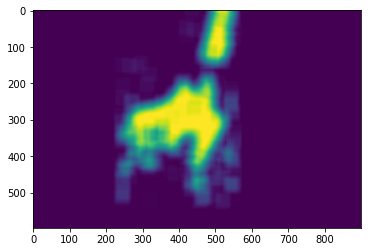

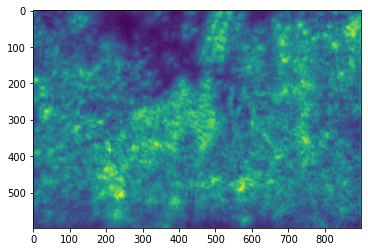

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


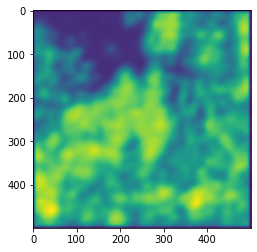

In [ ]:
i = 42

plt.imshow(clean_data[i])
plt.show()

plt.imshow(noisy_data[i])
plt.show()

plt.imshow(model(torch.unsqueeze(noisy_data_tensor[i], dim=0)).cpu().detach().numpy()[0][0])
plt.show()

4


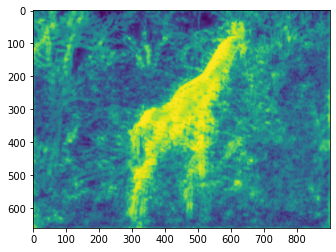

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


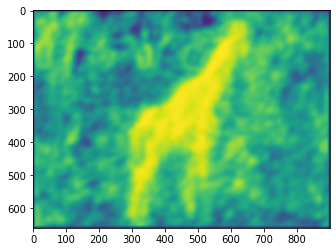

15


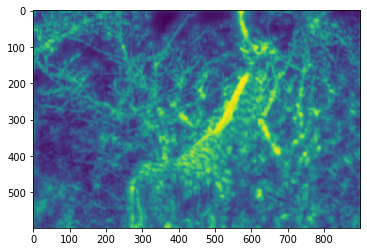

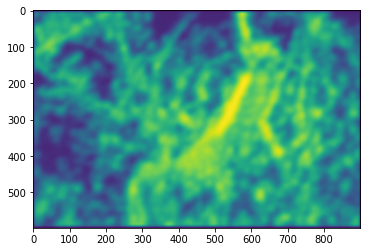

29


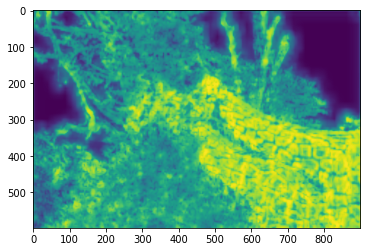

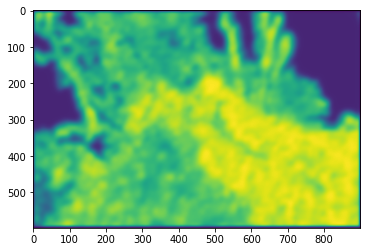

In [ ]:
noisy_imgs = [4, 15, 29]

for i in noisy_imgs:
    print(i)

    plt.imshow(act_maps[i])
    plt.show()

    plt.imshow(model(torch.unsqueeze(torch.unsqueeze(torch.tensor(act_maps[i]).cuda(), dim=0), dim=0)).cpu().detach().numpy()[0][0])
    plt.show()